In [15]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from skopt import BayesSearchCV
import subprocess
import matplotlib.pyplot as plt
import math  
import sklearn.metrics
import shap
from sklearn.tree import DecisionTreeRegressor

# Model Interpretability

In [16]:
df = pd.read_csv('airbnb_model_fitting.csv')

In [18]:
X = df.loc[:, df.columns != 'price']
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.1, train_size = 0.9,  random_state=42)

In [23]:
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression
import warnings
warnings.filterwarnings("ignore")

selector = SelectKBest(mutual_info_regression, k=13)

X_new = selector.fit_transform(X_train, y_train)

X_train_selected = X_train.iloc[:, selector.get_support(indices=True)]
X_test_selected = X_test.iloc[:, selector.get_support(indices=True)]

X_train_selected['bus_radius'] = X_train.iloc[:, X_train.columns.get_loc('bus_radius')]
X_train_selected['within_radius'] = X_train['within_radius']
#X_train_selected['average_nearest_price'] = X_train['average_nearest_price']
#X_train_selected['longitude'] = X_train['longitude']

X_test_selected['bus_radius'] = X_test['bus_radius']
X_test_selected['within_radius'] = X_test['within_radius']
#X_test_selected['average_nearest_price'] = X_test['average_nearest_price']
#X_test_selected['longitude'] = X_test['longitude']

X_train_selected.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3702 entries, 2846 to 860
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   latitude                   3702 non-null   float64
 1   longitude                  3702 non-null   float64
 2   host_total_listings_count  3702 non-null   int64  
 3   neighbourhood_cleansed     3702 non-null   int64  
 4   property_type              3702 non-null   int64  
 5   room_type                  3702 non-null   int64  
 6   accommodates               3702 non-null   int64  
 7   bedrooms                   3702 non-null   float64
 8   beds                       3702 non-null   float64
 9   high_end_electronics       3702 non-null   float64
 10  elevator                   3702 non-null   float64
 11  bathrooms_type             3702 non-null   int64  
 12  bathrooms_number           3702 non-null   float64
 13  bus_radius                 3702 non-null   int

In [5]:
'''
regressor = RandomForestRegressor(n_estimators = 100, max_features = 1, max_depth = 10, min_samples_split = 20)
regressor.fit(X_train, y_train)

feature_importances = regressor.feature_importances_

# Create a pandas dataframe of feature importances
df_importances = pd.DataFrame({'feature': list(range(X_train.shape[1])), 'importance': feature_importances}).sort_values('importance', ascending=False)

# Select features with highest importance scores
top_features = df_importances[df_importances['importance'] >= 0.02]['feature'].values.tolist()

X_train_selected = X_train.iloc[:, top_features]
X_test_selected = X_test.iloc[:, top_features]
X_train_selected.info()
'''

"\nregressor = RandomForestRegressor(n_estimators = 100, max_features = 1, max_depth = 10, min_samples_split = 20)\nregressor.fit(X_train, y_train)\n\nfeature_importances = regressor.feature_importances_\n\n# Create a pandas dataframe of feature importances\ndf_importances = pd.DataFrame({'feature': list(range(X_train.shape[1])), 'importance': feature_importances}).sort_values('importance', ascending=False)\n\n# Select features with highest importance scores\ntop_features = df_importances[df_importances['importance'] >= 0.02]['feature'].values.tolist()\n\nX_train_selected = X_train.iloc[:, top_features]\nX_test_selected = X_test.iloc[:, top_features]\nX_train_selected.info()\n"

In [24]:
X_train_selected.to_csv('preprocessed_X_train.csv',index=False)
y_train.to_csv('preprocessed_y_train.csv',index=False)
X_test_selected.to_csv('preprocessed_X_test.csv',index=False)
y_test.to_csv('preprocessed_y_test.csv',index=False)

In [25]:
subprocess.check_call(['jupyter', 'nbconvert', '--to', 'notebook', '--execute', 'feature_patch_1.ipynb'])

[NbConvertApp] Converting notebook feature_patch_1.ipynb to notebook
[NbConvertApp] Executing notebook with kernel: python3
[NbConvertApp] Writing 3745661 bytes to feature_patch_1.nbconvert.ipynb


0

## Waterflow

In [26]:
X_train_1 = X_train_selected
y_train_1 = y_train

X_test_1 = X_test_selected
y_test_1 = y_test

In [9]:
rf = RandomForestRegressor(n_estimators = 50, max_features = 'sqrt', max_depth = 30, random_state=42)
rf.fit(X_train_1, y_train_1)
y_predict_rf = rf.predict(X_test_1)

In [10]:
'''
importancesRF = rf.feature_importances_
feat_imp1 = pd.DataFrame(importancesRF, columns=['Weight'], index=X_train_1.columns)
feat_imp1.sort_values('Weight', inplace=True, ascending=False)
'''

"\nimportancesRF = rf.feature_importances_\nfeat_imp1 = pd.DataFrame(importancesRF, columns=['Weight'], index=X_train_1.columns)\nfeat_imp1.sort_values('Weight', inplace=True, ascending=False)\n"

In [11]:
'''
feat_imp = pd.DataFrame({'importance':rf.feature_importances_})  
feat_imp['feature'] = X_train_1.columns
feat_imp.sort_values(by='importance', ascending=False, inplace=True)

feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp = feat_imp[len(feat_imp1)-10:len(feat_imp1)]
feat_imp.plot.barh(figsize=(5,5))
plt.xlabel('Importance Score')
plt.ylabel('Top 10 Features')
plt.show()
'''

"\nfeat_imp = pd.DataFrame({'importance':rf.feature_importances_})  \nfeat_imp['feature'] = X_train_1.columns\nfeat_imp.sort_values(by='importance', ascending=False, inplace=True)\n\nfeat_imp.sort_values(by='importance', inplace=True)\nfeat_imp = feat_imp.set_index('feature', drop=True)\nfeat_imp = feat_imp[len(feat_imp1)-10:len(feat_imp1)]\nfeat_imp.plot.barh(figsize=(5,5))\nplt.xlabel('Importance Score')\nplt.ylabel('Top 10 Features')\nplt.show()\n"

In [12]:
mse = sklearn.metrics.mean_squared_error(y_test_1, y_predict_rf)  
mae_rf_1 = sklearn.metrics.mean_absolute_error(y_test_1, y_predict_rf) 

rmse_rf_1 = math.sqrt(mse)  

print("RMSE = ", rmse_rf_1)
print("MAE = ", mae_rf_1)

RMSE =  55.24199287950487
MAE =  41.302292513323216


In [13]:
"""
from dtreeviz.trees import *

selected_tree = rf.estimators_[0]

viz_model = dtreeviz(selected_tree,
                       x_data=X_train_1,
                       y_data=y_train_1,
                       target_name='price',
                       feature_names=X_train_1.columns)
viz_model.save("tree.svg")
"""

'\nfrom dtreeviz.trees import *\n\nselected_tree = rf.estimators_[0]\n\nviz_model = dtreeviz(selected_tree,\n                       x_data=X_train_1,\n                       y_data=y_train_1,\n                       target_name=\'price\',\n                       feature_names=X_train_1.columns)\nviz_model.save("tree.svg")\n'

## Shaply without nearest_airbnb_price_8 

In [27]:
rf = RandomForestRegressor(n_estimators = 150, max_features = 'sqrt', max_depth = 20, random_state=42)

rf.fit(X_train_1, y_train_1)
y_predict_gb = rf.predict(X_test_1)

In [28]:
mse = sklearn.metrics.mean_squared_error(y_test_1, y_predict_gb)  
mae_gb_1 = sklearn.metrics.mean_absolute_error(y_test_1, y_predict_gb) 

rmse_gb_1 = math.sqrt(mse)  

print("RMSE = ", rmse_gb_1)
print("MAE = ", mae_gb_1)

RMSE =  51.88195772826869
MAE =  38.52207252609187


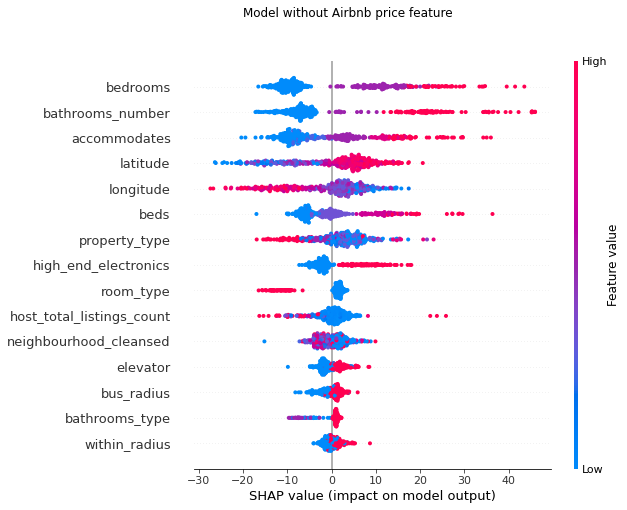

In [30]:
shap.initjs()
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test_1)
fig = plt.gcf()
shap.summary_plot(shap_values, X_test_1, show=False)
fig.suptitle('Model without Airbnb price feature                                ')
#shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_1.iloc[0,:])
fig.savefig('shap_summary_rf_model1.png', dpi=300, bbox_inches="tight")

## Shaply with nearest_airbnb_price_8 

In [31]:
X_test_2 = pd.read_csv('preprocessed_2_X_test_2.csv', sep=',')
y_test_2 = pd.read_csv('preprocessed_2_y_test_2.csv', sep=',')
X_train_2 = pd.read_csv('preprocessed_2_X_train.csv', sep=',')
y_train_2 = pd.read_csv('preprocessed_2_y_train.csv', sep=',')

In [32]:
rf_2 = RandomForestRegressor(n_estimators = 150, max_features = 'log2', max_depth = 10, random_state=42)

rf_2.fit(X_train_2, y_train_2)
y_predict_gb_2 = rf_2.predict(X_test_2)

In [33]:
mse = sklearn.metrics.mean_squared_error(y_test_2, y_predict_gb_2)  
mae_gb_2 = sklearn.metrics.mean_absolute_error(y_test_2, y_predict_gb_2) 

rmse_gb_2 = math.sqrt(mse)  

print("RMSE = ", rmse_gb_2)
print("MAE = ", mae_gb_2)

RMSE =  49.425685973097025
MAE =  33.125569338103155


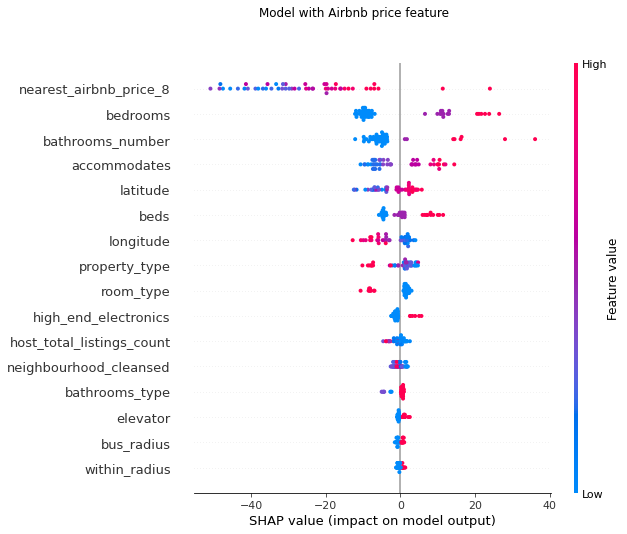

In [34]:
explainer = shap.TreeExplainer(rf_2)
shap_values = explainer.shap_values(X_test_2)
fig=plt.gcf()
shap.summary_plot(shap_values, X_test_2, show=False)
fig.suptitle('Model with Airbnb price feature                             ')
fig.savefig('shap_summary_rf_model2.png', dpi=300, bbox_inches="tight")